In [1]:
# Apart from being a copy of trigram notebook and having all the notes from it,
# I added E06 here. It was a lot of discussion on discord what should we use
# for NN training 27^2 rows or 27*2. 27^2 is a reasonable choice representing 
# all possible bigrams with respective positions encoded. The loss achieved
# using 27^2 weights setting train loss: 2.27708, dev loss: 2.30231, test loss: 2.29033.
# The claim of this experiment: we can achieve similar results using 27*2 weights settings
# First 27 rows encode first character of bigram and second 27 encode second character.
# Position matters: 'ab' and 'ba' are represented by sum(W[1], W[29]) and sum(W[2], W[28]) respectevly.
# The hard part for the NN to learn is one row will participate in 27 possible combinations (bigrams),
# and has to encode statististics of these combinations somehow. On the other hand our 27^2 weights
# setting has unique row for every bigram.

In [2]:
### E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. 
### Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?
### Doesn't look like a very big improvement to me.

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [5]:
len(words)

32033

In [6]:
min(len(w) for w in words)

2

In [7]:
max(len(w) for w in words)

15

In [8]:
t = {}
for w in words:
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    trigram = (ch1, ch2, ch3)
    t[trigram] = t.get(trigram, 0) + 1

In [9]:
sorted(t.items(), key = lambda kv: -kv[1])

[(('a', 'h', '<E>'), 1714),
 (('n', 'a', '<E>'), 1673),
 (('a', 'n', '<E>'), 1509),
 (('o', 'n', '<E>'), 1503),
 (('<S>', 'm', 'a'), 1453),
 (('<S>', 'j', 'a'), 1255),
 (('<S>', 'k', 'a'), 1254),
 (('e', 'n', '<E>'), 1217),
 (('l', 'y', 'n'), 976),
 (('y', 'n', '<E>'), 953),
 (('a', 'r', 'i'), 950),
 (('i', 'a', '<E>'), 903),
 (('i', 'e', '<E>'), 858),
 (('a', 'n', 'n'), 825),
 (('e', 'l', 'l'), 822),
 (('a', 'n', 'a'), 804),
 (('i', 'a', 'n'), 790),
 (('m', 'a', 'r'), 776),
 (('i', 'n', '<E>'), 766),
 (('e', 'l', '<E>'), 727),
 (('y', 'a', '<E>'), 716),
 (('a', 'n', 'i'), 703),
 (('<S>', 'd', 'a'), 700),
 (('l', 'a', '<E>'), 684),
 (('e', 'r', '<E>'), 683),
 (('i', 'y', 'a'), 669),
 (('l', 'a', 'n'), 647),
 (('<S>', 'b', 'r'), 646),
 (('n', 'n', 'a'), 633),
 (('<S>', 'a', 'l'), 632),
 (('<S>', 'c', 'a'), 628),
 (('r', 'a', '<E>'), 627),
 (('n', 'i', '<E>'), 625),
 (('<S>', 'a', 'n'), 623),
 (('n', 'n', '<E>'), 619),
 (('n', 'e', '<E>'), 607),
 (('e', 'e', '<E>'), 605),
 (('e', 'y', '<

In [10]:
import random
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# lets check if we have same shuffle in both notebooks using our own local random object,
# with the same seed - it works
r = random.Random(2147483647)
r.shuffle(words)
words[:5]

['khole', 'harbour', 'devon', 'baine', 'erisha']

In [12]:
# Split into train/dev/test set
p80 = int(len(words) * 0.8)
p90 = int(len(words) * 0.9)
print(f'{p80=}, {p90=}')
train = words[:p80]
dev = words[p80:p90]
test = words[p90:]
print(f'train %: {len(train)/len(words)*100}, dev %: {len(dev)/len(words)*100}, test %: {len(test)/len(words)*100}')

p80=25626, p90=28829
train %: 79.99875128773452, dev %: 9.999063465800893, test %: 10.002185246464583


In [13]:
print(train[:5])
print(dev[:5])
print(test[:5])

['khole', 'harbour', 'devon', 'baine', 'erisha']
['shterna', 'tyanna', 'sarra', 'malachy', 'zenaya']
['phoenyx', 'christionna', 'bastien', 'niloufar', 'masa']


In [14]:
# pair -> char
# m = number of pairs; n = number of chars: same as in bigrams
# so our matrix of counts/probs will be m x n

In [15]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [16]:
# We actually need all possible pairs of our chars, as sampling can come up
# with a pair not seen it the actual data. 27*27

In [17]:
# same as with chars, but we need all pairs
pairs = []
for i in range(27):
  for j in range(27):
    pairs.append(itos[i] + itos[j])
pairs.sort()
# need to populate pair to ix and ix to pair dicts
pairtoi = {p:i for i,p in enumerate(pairs)}
itopair = {i:p for p,i in pairtoi.items()}

In [18]:
len(pairtoi), len(stoi)

(729, 27)

In [19]:
# Matrix of counts how often a pair followed by a char
# we build it only from train dataset
N = torch.zeros((729, 27), dtype=torch.int32)
for w in train:
  # as we now using pairs, we start with ..
  # didn't come up with better solution
  chs = ['.', '.'] + list(w) + ['.']
  # we can use indecies, but for simplicity just 3 iters
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = pairtoi[ch1+ch2]
    ix2 = stoi[ch3]
    N[ix1, ix2] += 1
    

In [20]:
N[0]

tensor([   0, 3522, 1040, 1238, 1351, 1248,  349,  534,  713,  477, 1935, 2305,
        1272, 2026,  941,  310,  412,   75, 1304, 1634, 1036,   68,  296,  244,
         110,  443,  743], dtype=torch.int32)

In [21]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1374, 0.0406, 0.0483, 0.0527, 0.0487, 0.0136, 0.0208, 0.0278,
        0.0186, 0.0755, 0.0899, 0.0496, 0.0791, 0.0367, 0.0121, 0.0161, 0.0029,
        0.0509, 0.0638, 0.0404, 0.0027, 0.0116, 0.0095, 0.0043, 0.0173, 0.0290])

In [22]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'j'

In [23]:
P = (N+1).float() # N+1 is smoothing, so to not have inf loss on zero prob
P /= P.sum(1, keepdims=True)

In [24]:
P[1].sum()

tensor(1.)

In [25]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(10):
  
  out = ['.']  # prepopulate with first .
  i = 0 # start sampling from what char follows '..'
  while True:
    p = P[i]
    j = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[j])
    if j == 0: # we've sampled end of word
      break
    # update index i
    pair = ''.join(out[-2:])  # last 2 chars
    i = pairtoi[pair]

  print(''.join(out[1:]))

junide.
janasid.
prelay.
adin.
kairritoper.
sathen.
sameia.
yanileniassibduinrwin.
lessiyanayla.
te.


In [26]:
# Trying different seeds, it looks like more generated words became name-like. Tend to generate very long words as well.

In [27]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

In [28]:
# evaluate on train
log_likelihood = 0.0
n = 0

for w in train:
# for w in ["alexey"]:
  chs = ['.', '.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = pairtoi[ch1+ch2]
    ix2 = stoi[ch3]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    # print(f'{ch1}{ch2}{ch3}: {prob:.4f} {logprob:.4f}')

print('evaluate on train')
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

evaluate on train
log_likelihood=tensor(-404414.3438)
nll=tensor(404414.3438)
2.2154107093811035


In [29]:
# evaluate on dev
log_likelihood = 0.0
n = 0

for w in dev:
# for w in ["alexey"]:
  chs = ['.', '.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = pairtoi[ch1+ch2]
    ix2 = stoi[ch3]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    # print(f'{ch1}{ch2}{ch3}: {prob:.4f} {logprob:.4f}')

print('evaluate on dev')
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

evaluate on dev
log_likelihood=tensor(-51308.7266)
nll=tensor(51308.7266)
2.246441602706909


In [30]:
# evaluate on test
log_likelihood = 0.0
n = 0

for w in test:
# for w in ["alexey"]:
  chs = ['.', '.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = pairtoi[ch1+ch2]
    ix2 = stoi[ch3]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    # print(f'{ch1}{ch2}{ch3}: {prob:.4f} {logprob:.4f}')

print('evaluate on test')
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

evaluate on test
log_likelihood=tensor(-50781.2344)
nll=tensor(50781.2344)
2.23116135597229


In [31]:
# Increasing context to have a probability of char following a pair improves loss.
# Also, the loss is slightly worse on dev and test data, train data counts do not
# ideally correspond to dev and test data statistics

In [44]:
# create the training set of trigrams (x,y)
xs, ys = [], []

for w in words[:1]:
  chs = ['.', '.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1, ix2 = stoi[ch1], stoi[ch2] + 27
    ix3 = stoi[ch3]
    print(ch1, ch2, ch3)
    xs.append([ix1, ix2])
    ys.append(ix3)
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

. . k
. k h
k h o
h o l
o l e
l e .


In [45]:
xs

tensor([[ 0, 27],
        [ 0, 38],
        [11, 35],
        [ 8, 42],
        [15, 39],
        [12, 32]])

In [46]:
ys

tensor([11,  8, 15, 12,  5,  0])

In [89]:
words[:1]

['khole']

In [49]:
import torch.nn.functional as F

In [51]:
W = torch.randn((27*2, 27))

In [68]:
# Indexing with a pairs of xs, gives us corresponding rows of W
# same as we have 2-hot encoded vector. Next step we have to sum up them.
W[xs].sum(1, keepdims=False)

tensor([ 0.0725,  2.5093,  1.3629,  0.5405, -1.1535, -2.4270, -0.6492, -1.0269,
         1.5020, -0.5997,  0.2702,  1.7702, -1.0255,  1.1606, -0.0054, -0.8142,
         1.1321, -0.3822,  0.4059, -0.1406,  0.0978,  1.9276,  2.1564, -0.0390,
        -1.2573, -0.8145, -0.5943])

In [60]:
xs[0]

tensor([ 0, 27])

In [71]:
(W[0] + W[27] == W[xs].sum(1, keepdims=False)[0]).all()

tensor(True)

In [72]:
logits = W[xs].sum(1, keepdims=False) # log-counts
counts = logits.exp() # not so equivalent N
probs = counts / counts.sum(1, keepdims=True)
probs

tensor([[1.7203e-02, 1.9674e-01, 6.2515e-02, 2.7469e-02, 5.0484e-03, 1.4128e-03,
         8.3591e-03, 5.7299e-03, 7.1849e-02, 8.7838e-03, 2.0964e-02, 9.3952e-02,
         5.7378e-03, 5.1066e-02, 1.5913e-02, 7.0876e-03, 4.9635e-02, 1.0917e-02,
         2.4010e-02, 1.3902e-02, 1.7643e-02, 1.0996e-01, 1.3824e-01, 1.5388e-02,
         4.5507e-03, 7.0854e-03, 8.8312e-03],
        [6.3669e-02, 1.1258e-01, 1.1460e-01, 3.0807e-02, 5.1099e-03, 9.0968e-03,
         6.5685e-03, 8.6753e-03, 2.2207e-02, 4.1299e-02, 6.8685e-02, 2.6974e-02,
         2.0243e-03, 2.1588e-02, 2.0637e-01, 4.1260e-03, 1.7324e-02, 6.1824e-03,
         2.1772e-02, 5.2538e-02, 5.3875e-03, 1.5251e-02, 4.9805e-02, 3.3051e-02,
         3.9236e-02, 9.2678e-03, 5.8069e-03],
        [4.5665e-03, 1.9175e-03, 1.9667e-02, 3.7423e-02, 7.0564e-02, 9.4850e-02,
         1.8299e-03, 4.2525e-02, 6.9463e-02, 1.2440e-02, 3.6012e-03, 5.3455e-03,
         5.6626e-03, 5.0339e-03, 9.0505e-03, 2.6853e-01, 2.8551e-02, 3.2115e-02,
         5.4624e-

In [73]:
probs[0]

tensor([0.0172, 0.1967, 0.0625, 0.0275, 0.0050, 0.0014, 0.0084, 0.0057, 0.0718,
        0.0088, 0.0210, 0.0940, 0.0057, 0.0511, 0.0159, 0.0071, 0.0496, 0.0109,
        0.0240, 0.0139, 0.0176, 0.1100, 0.1382, 0.0154, 0.0046, 0.0071, 0.0088])

In [74]:
probs[0].shape

torch.Size([27])

In [75]:
probs[0].sum()

tensor(1.0000)

In [161]:
# SUMMARY ------------------------------>>>>

In [76]:
xs

tensor([[ 0, 27],
        [ 0, 38],
        [11, 35],
        [ 8, 42],
        [15, 39],
        [12, 32]])

In [77]:
ys

tensor([11,  8, 15, 12,  5,  0])

In [78]:
# randomly initialize 27 neurons' weights. each neuron receives 729 inputs (all possible pairs)
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27*2, 27), generator=g)

In [79]:
# no wasteful one-hot encoding
logits  = W[xs].sum(1, keepdims=False) # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
# btw: the last 2 lines here are together called a 'softmax'

In [88]:

nlls = torch.zeros(6)
for i in range(6):
  # i-th bigram:
  x1, x2 = xs[i,0].item(), xs[i,1].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'trigram example {i+1}: {itos[x1]}{itos[x2-27]}{itos[y]} (indexes {x1,x2},{y})')
  print('input to the neural net:', x1, x2)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
trigram example 1: ..k (indexes (0, 27),11)
input to the neural net: 0 27
output probabilities from the neural net: tensor([0.0820, 0.0239, 0.0099, 0.0032, 0.0036, 0.0026, 0.0019, 0.0316, 0.0136,
        0.0071, 0.0078, 0.0332, 0.0025, 0.0029, 0.1489, 0.3053, 0.0207, 0.0020,
        0.0181, 0.0036, 0.0194, 0.0037, 0.0005, 0.0085, 0.0094, 0.0734, 0.1608])
label (actual next character): 11
probability assigned by the net to the the correct character: 0.033166516572237015
log likelihood: -3.406214475631714
negative log likelihood: 3.406214475631714
--------
trigram example 2: .kh (indexes (0, 38),8)
input to the neural net: 0 38
output probabilities from the neural net: tensor([1.7563e-02, 3.8977e-03, 5.7618e-03, 9.2975e-03, 9.5304e-03, 5.3843e-03,
        1.5667e-03, 8.9767e-03, 9.2242e-03, 4.9584e-03, 1.6703e-03, 4.1333e-03,
        1.0863e-02, 2.6199e-03, 2.4008e-02, 4.7337e-01, 4.7484e-02, 3.8913e-03,
        1.7930e-03, 1.5685e-03, 7.8645e-02, 2.3512e-03, 3.8093e-04, 7.8608e

In [90]:
# --------- !!! OPTIMIZATION !!! yay --------------

In [93]:
xs

tensor([[ 0, 27],
        [ 0, 38],
        [11, 35],
        [ 8, 42],
        [15, 39],
        [12, 32]])

In [94]:
ys

tensor([11,  8, 15, 12,  5,  0])

In [96]:
# randomly initialize 27 neurons' weights. each neuron receives 27*2 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27*2, 27), generator=g, requires_grad=True)

In [115]:
# forward pass
logits  = W[xs].sum(1, keepdims=False)
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(6), ys].log().mean()

In [116]:
print(loss.item())

4.379533290863037


In [117]:
# forward pass with ex.4 and ex.5 updates
logits  = W[xs].sum(1, keepdims=False)
loss = F.cross_entropy(logits, ys)

In [118]:
print(loss.item())

4.379532814025879


In [119]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()

In [120]:
W.data += -0.1 * W.grad

In [56]:
# --------- !!! OPTIMIZATION !!! yay, but this time actually --------------

In [125]:
# create train dataset
xs, ys = [], []
for w in train:
  chs = ['.', '.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1, ix2 = stoi[ch1], stoi[ch2] + 27
    ix3 = stoi[ch3]
    xs.append([ix1, ix2])
    ys.append(ix3)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of train examples: ', num // 2)

# create dev dataset
xdevs, ydevs = [], []
for w in dev:
  chs = ['.', '.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1, ix2 = stoi[ch1], stoi[ch2] + 27
    ix3 = stoi[ch3]
    xdevs.append([ix1, ix2])
    ydevs.append(ix3)
xdevs = torch.tensor(xdevs)
ydevs = torch.tensor(ydevs)
num_dev = xdevs.nelement()
print('number of dev examples: ', num_dev // 2)

number of train examples:  182546
number of dev examples:  22840


In [126]:
def plot_train_dev_loss(train_losses, dev_losses, reg_strength):
  plt.plot(train_losses, label='train')
  plt.plot(dev_losses, label='dev')
  plt.xlabel('Epoch')
  plt.ylabel('NLL Loss')
  plt.title(f'Reg Strength: {reg_strength}')
  plt.legend()
  plt.show()

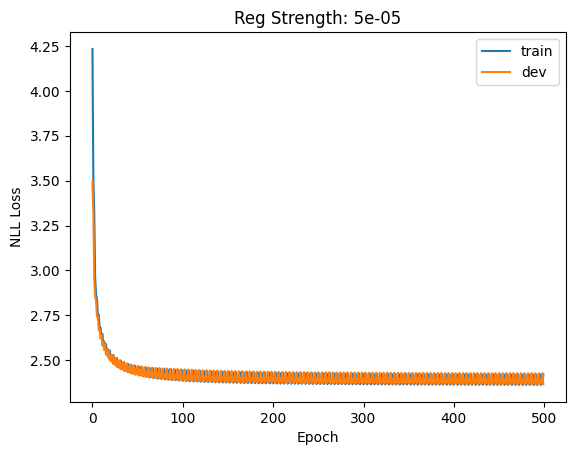

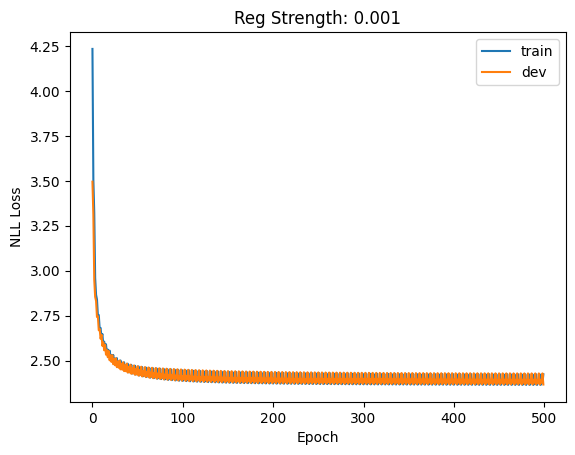

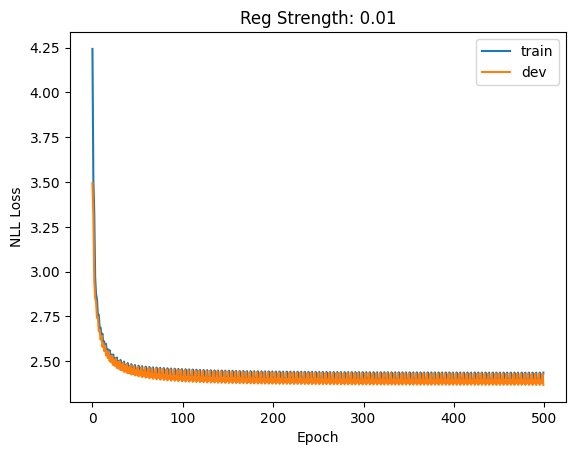

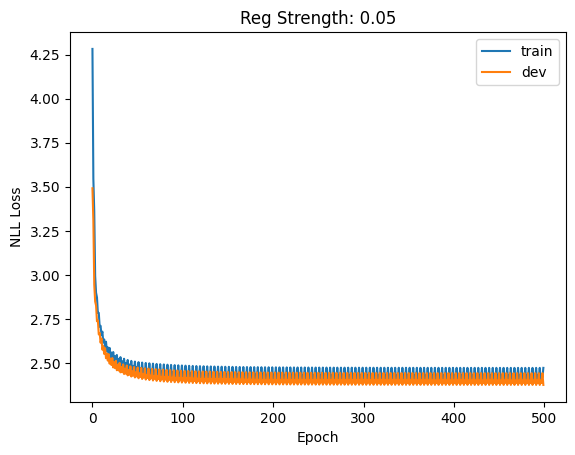

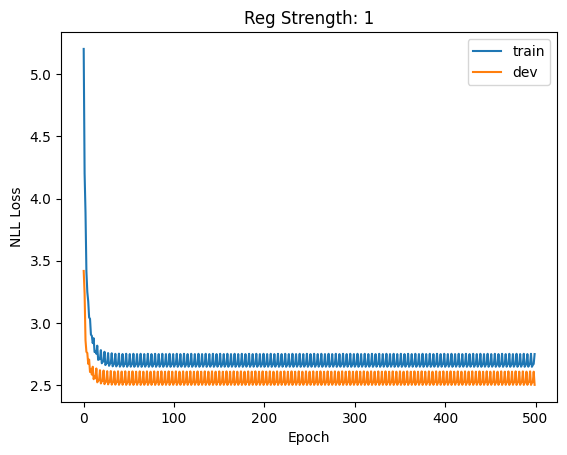

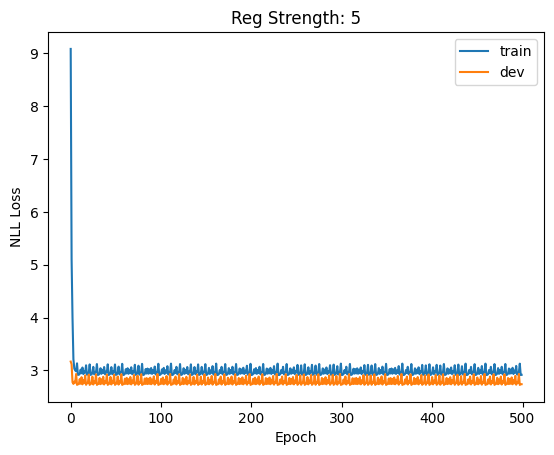

In [127]:
# E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - 
# i.e. try many possibilities and see which one works best based on the dev set loss. 
# What patterns can you see in the train and dev set loss as you tune this strength? 
# Take the best setting of the smoothing and evaluate on the test set once and at the end. 
# How good of a loss do you achieve?

# First intuition. The loss has two components. 1. To initiativize learning weights
# to predict probabilities of a character following a pair as it was seen in training data.
# 2. To penalize for large weight^2 / to push weights closer to zero everywhere. They are competing
# forces. To predict better we need some weights to be larger and some to be smaller. For second 
# loss component ideal will be all W to be zero, but then predictions will be just uniform.

# When evaluating on dev set, we can't clearly compare only NLL components of the overall loss,
# but we actually mostly care about it. We can remove regularization component from the dev loss.
# This way we can see, how different regularization strengths during training influence our NLL dev loss.

# E04. We change code here to remove one-hot encoding and simply index into weights.
# Removing one-hot encoding and eventually matrix multiplication speed-up the process significantly!

# E05. Change our manual softmax -> nll into cross_entropy. CE ~ LogSoftMax followed by NLL
# Why LogSoftMax? gradient of log(p(x)) is usually much better scaled than gradient of p(x)
# which implies a better fit for gradient optimization.

experiments = {}

# every iteration is one experiment with some regularization strength
for reg_strength in [0.00005, 0.001, 0.01, 0.05, 1, 5]:
  # initialize the 'network' for every experiment
  g = torch.Generator().manual_seed(2147483647)
  W = torch.randn((27*2, 27), generator=g, requires_grad=True)
  train_losses = []
  dev_losses = []
  
  for k in range(500):
    
    # forward pass
    logits = W[xs].sum(1, keepdims=False) # predict log-counts
    loss = F.cross_entropy(logits, ys) + reg_strength*(W**2).mean()
    train_losses.append(loss.item())
    # backward pass
    W.grad = None # set to zero the gradient
    loss.backward()
    # update
    W.data += -50 * W.grad
    
    # forward pass to evaluate loss
    with torch.no_grad():
      logits = W[xdevs].sum(1, keepdims=False) # predict log-counts
      loss = F.cross_entropy(logits, ydevs) # only want to see NLL part
      dev_losses.append(loss.item())

  # plot after finishing experiment
  plot_train_dev_loss(train_losses, dev_losses, reg_strength)
  # save experiment data
  experiments[str(reg_strength)] = [train_losses, dev_losses]

In [128]:
for k, v in experiments.items():
  print(f'{k}, final train loss: {v[0][-1]}, final dev loss: {v[1][-1]}')

5e-05, final train loss: 2.4218814373016357, final dev loss: 2.366365909576416
0.001, final train loss: 2.423424005508423, final dev loss: 2.366398811340332
0.01, final train loss: 2.435990571975708, final dev loss: 2.3672797679901123
0.05, final train loss: 2.4724624156951904, final dev loss: 2.375762939453125
1, final train loss: 2.7488534450531006, final dev loss: 2.501415491104126
5, final train loss: 2.914701461791992, final dev loss: 2.7379066944122314


evaluate loss on test dataset
number of test examples:  22760


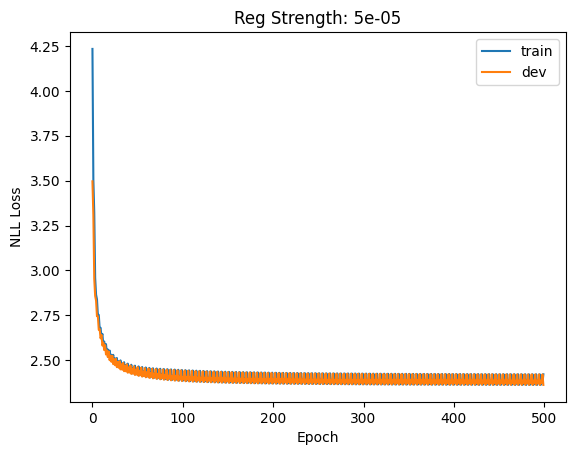

In [136]:
# create the dataset from test data
print('evaluate loss on test dataset')
xtests, ytests = [], []
for w in test:
  chs = ['.', '.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1,ix2 = stoi[ch1], stoi[ch2] + 27
    ix3 = stoi[ch3]
    xtests.append([ix1,ix2])
    ytests.append(ix3)
xtests = torch.tensor(xtests)
ytests = torch.tensor(ytests)
num_test = xtests.nelement()
print('number of test examples: ', num_test // 2)

# we remove one-hot encoding (ex. 4)

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27*2, 27), generator=g, requires_grad=True)
train_losses = []
dev_losses = []

# train model with the best regularization settings
for k in range(500):
  
  # forward pass
  logits = W[xs].sum(1, keepdims=False) # predict log-counts
  # counts = logits.exp() # counts, equivalent to N
  # probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  # loss = -probs[torch.arange(num), ys].log().mean() + 0.05*(W**2).mean() # best on dev set
  loss = F.cross_entropy(logits, ys) + 0.00005*(W**2).mean()  # E05 change
  train_losses.append(loss.item())
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  # update
  W.data += -50 * W.grad
  
  # forward pass to evaluate loss
  with torch.no_grad():
    logits = W[xtests].sum(1, keepdims=False) # predict log-counts
    # counts = logits.exp() # counts, equivalent to N
    # probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # loss = -probs[torch.arange(num_test), ytests].log().mean() # only want to see NLL part
    loss = F.cross_entropy(logits, ytests)  # E05 change
    dev_losses.append(loss.item())

# plot after finishing experiment
plot_train_dev_loss(train_losses, dev_losses, 0.00005)

In [137]:
train_losses[-1], dev_losses[-1]

(2.4218807220458984, 2.362800359725952)

In [141]:
# The loss for nn trigram model  with 27*2 weight setting achieved a bit worse loss compared to 27^2 setting.
# Adjusting weights rows which are not only part of unique pair but 27 pairs seems to be a harder task.
# Interesting part is to check loss graphs. They are very unstable and fluctuate a lot between epochs.
# I guess, it kinda prove the point, that it is harder to ajust weights rows in such a way, so to 
# satisfy all bigram representations they carry.
# If you check generation: this 27*2 weight setting does roughly as well as its 27^2 counterpart.

In [161]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for _ in range(5):
  
  out = []
  ix1, ix2 = 0, 27 # ..
  while True:
    
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    logits = W[[ix1, ix2]].sum(0, keepdims=True) # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------

    # move indecies
    ix1 = ix2 % 27 # we need to tap into first 27 rows here as this part of weights is for first character of pair
    ix2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() + 27 # add 27 to tap into second part of weights
    out.append(itos[ix2 % 27])
    if ix2 == 27:
      break
  print(''.join(out))

junide.
janasad.
pariay.
adin.
kai.


In [153]:
W[0] + W[27]

tensor([-5.4199,  2.9667,  1.2122,  1.3803,  1.4570,  0.8513,  0.1361,  0.5571,
         0.7994,  0.2557,  1.7863,  1.9009,  1.3594,  1.7898,  1.1056, -0.1612,
         0.2979, -1.3992,  1.3563,  1.6238,  1.2051, -1.5566, -0.0357, -0.2240,
        -1.0005,  0.3184,  0.8799], grad_fn=<AddBackward0>)